# Control


In [23]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np
import os
import tempfile
sns.set_theme(style="whitegrid")


In [24]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

# Load hg38 peaks

1. Create dataset without control tracks
2. Launch peak calling

```
conda activate snakemake
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True span=False sicer=False --rerun-trigger mtime;
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1" macs2_suffix="broad0.1"  span=False sicer=False --rerun-trigger mtime; 
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=False span=True sicer=True --rerun-trigger mtime;
```


In [25]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
GSE26320_NO_CONTROL_PATH = os.path.expanduser('~/data/2023_GSE26320_no_control')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
MODIFICATIONS = ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']

IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
IMMUNE_NO_CONTROL_PATH = os.path.expanduser('~/data/2023_Immune_no_control')
IMMUNE_CELLS = ['CD4ABT', 'TCellBB', 'BCell', 'TCell', 'Monocyte', 'PBMC', 'NK', 'CD34', 'CD4', ]  ## Longest first
IMMUNE_REPS = ['rep1', 'rep2', 'rep3', '']

! mkdir -p {GSE26320_PATH}/pics
! mkdir -p {IMMUNE_PATH}/pics

In [26]:
TOOLS = ['MACS2', 'MACS2 broad', 'SICER', 'HOMER', 'Hotspot', 'Peakseq', 'SPAN']
palette = plt.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}
TOOLS = ['MACS2', 'MACS2 broad', 'SICER', 'HOMER', 'Hotspot',  'SPAN']

In [27]:
def load_peaks(path, suffix, modifications, cells, replicates):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks'],
                      dtype=object)
    if not os.path.exists(path):
        return df
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        cell = next((c for c in cells if c in f), None)
        mod = next((m for m in modifications if m in f), None)
        rep = next((r for r in replicates if r in f), None)
        if cell and mod and rep is not None:
            peaks_path = os.path.join(path, f)
            ps = lines(peaks_path)
            df.loc[len(df)] = (peaks_path, mod, cell, rep, ps)
    return df

In [28]:
def load_peaks_path(path, modifications, cells, replicates):
    df_macs2 = load_peaks(os.path.join(path, 'macs2'), '.narrowPeak', modifications, cells, replicates)
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(os.path.join(path, 'macs2'), '.broadPeak', modifications, cells, replicates)
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(os.path.join(path, 'sicer'), 'summary-FDR0.01', modifications, cells, replicates)
    if len(df_sicer) == 0:
        df_sicer = load_peaks(os.path.join(path, 'sicer'), 'E100.scoreisland', modifications, cells, replicates) 
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = load_peaks(os.path.join(path, 'span'), '.peak', modifications, cells, replicates)
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    df_homer = load_peaks(os.path.join(path, 'homer'), '.peaks', modifications, cells, replicates)
    df_homer['tool'] = 'HOMER'
    print('HOMER', len(df_homer))

    df_hotspot = load_peaks(os.path.join(path, 'hotspot'), '.peak', modifications, cells, replicates)
    df_hotspot['tool'] = 'Hotspot'
    print('Hotspot', len(df_hotspot))

    # df_peakseq = load_peaks(os.path.join(path, 'peakseq'), '.narrowPeak', modifications, cells, replicates)
    # df_peakseq['tool'] = 'Peakseq'
    # print('Peakseq', len(df_peakseq))

    return pd.concat([df_macs2, df_macs2broad, df_sicer, df_span, df_homer, df_hotspot]).reset_index(drop=True)

In [29]:
df_encode_peaks = load_peaks_path(GSE26320_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_peaks['dataset'] = 'ENCODE'
df_encode_peaks['control'] = True

df_encode_no_control_peaks = load_peaks_path(GSE26320_NO_CONTROL_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_no_control_peaks['dataset'] = 'ENCODE'
df_encode_no_control_peaks['control'] = False

df_immune_peaks = load_peaks_path(IMMUNE_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_peaks['dataset'] = 'Roadmap'
df_immune_peaks['control'] = True

df_immune_no_control_peaks = load_peaks_path(IMMUNE_NO_CONTROL_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_no_control_peaks['dataset'] = 'Roadmap'
df_immune_no_control_peaks['control'] = False

df_peaks_full = pd.concat([df_encode_peaks, df_encode_no_control_peaks, 
                      df_immune_peaks, df_immune_no_control_peaks]).reset_index(drop=True)
df_peaks_full.sample(3)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/85 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/358 [00:00<?, ?it/s]

SPAN 85


  0%|          | 0/85 [00:00<?, ?it/s]

HOMER 85


  0%|          | 0/85 [00:00<?, ?it/s]

Hotspot 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/341 [00:00<?, ?it/s]

SPAN 85


  0%|          | 0/85 [00:00<?, ?it/s]

HOMER 85


  0%|          | 0/85 [00:00<?, ?it/s]

Hotspot 85


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 46


  0%|          | 0/47 [00:00<?, ?it/s]

SICER 46


  0%|          | 0/194 [00:00<?, ?it/s]

SPAN 46


  0%|          | 0/46 [00:00<?, ?it/s]

HOMER 46


  0%|          | 0/46 [00:00<?, ?it/s]

Hotspot 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 46


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

SICER 46


  0%|          | 0/184 [00:00<?, ?it/s]

SPAN 46


  0%|          | 0/46 [00:00<?, ?it/s]

HOMER 46


  0%|          | 0/46 [00:00<?, ?it/s]

Hotspot 46


,file,modification,cell,replicate,peaks,tool,dataset,control
885,/home/jetbrains/data/2023_GSE26320_no_control/...,H3K4me3,HMEC,rep1,34571,HOMER,ENCODE,False
1337,/home/jetbrains/data/2023_Immune_no_control/ma...,H3K27me3,CD4,,113,MACS2,Roadmap,False
592,/home/jetbrains/data/2023_GSE26320_no_control/...,H3K36me3,HepG2,rep1,40,MACS2,ENCODE,False


ENCODE


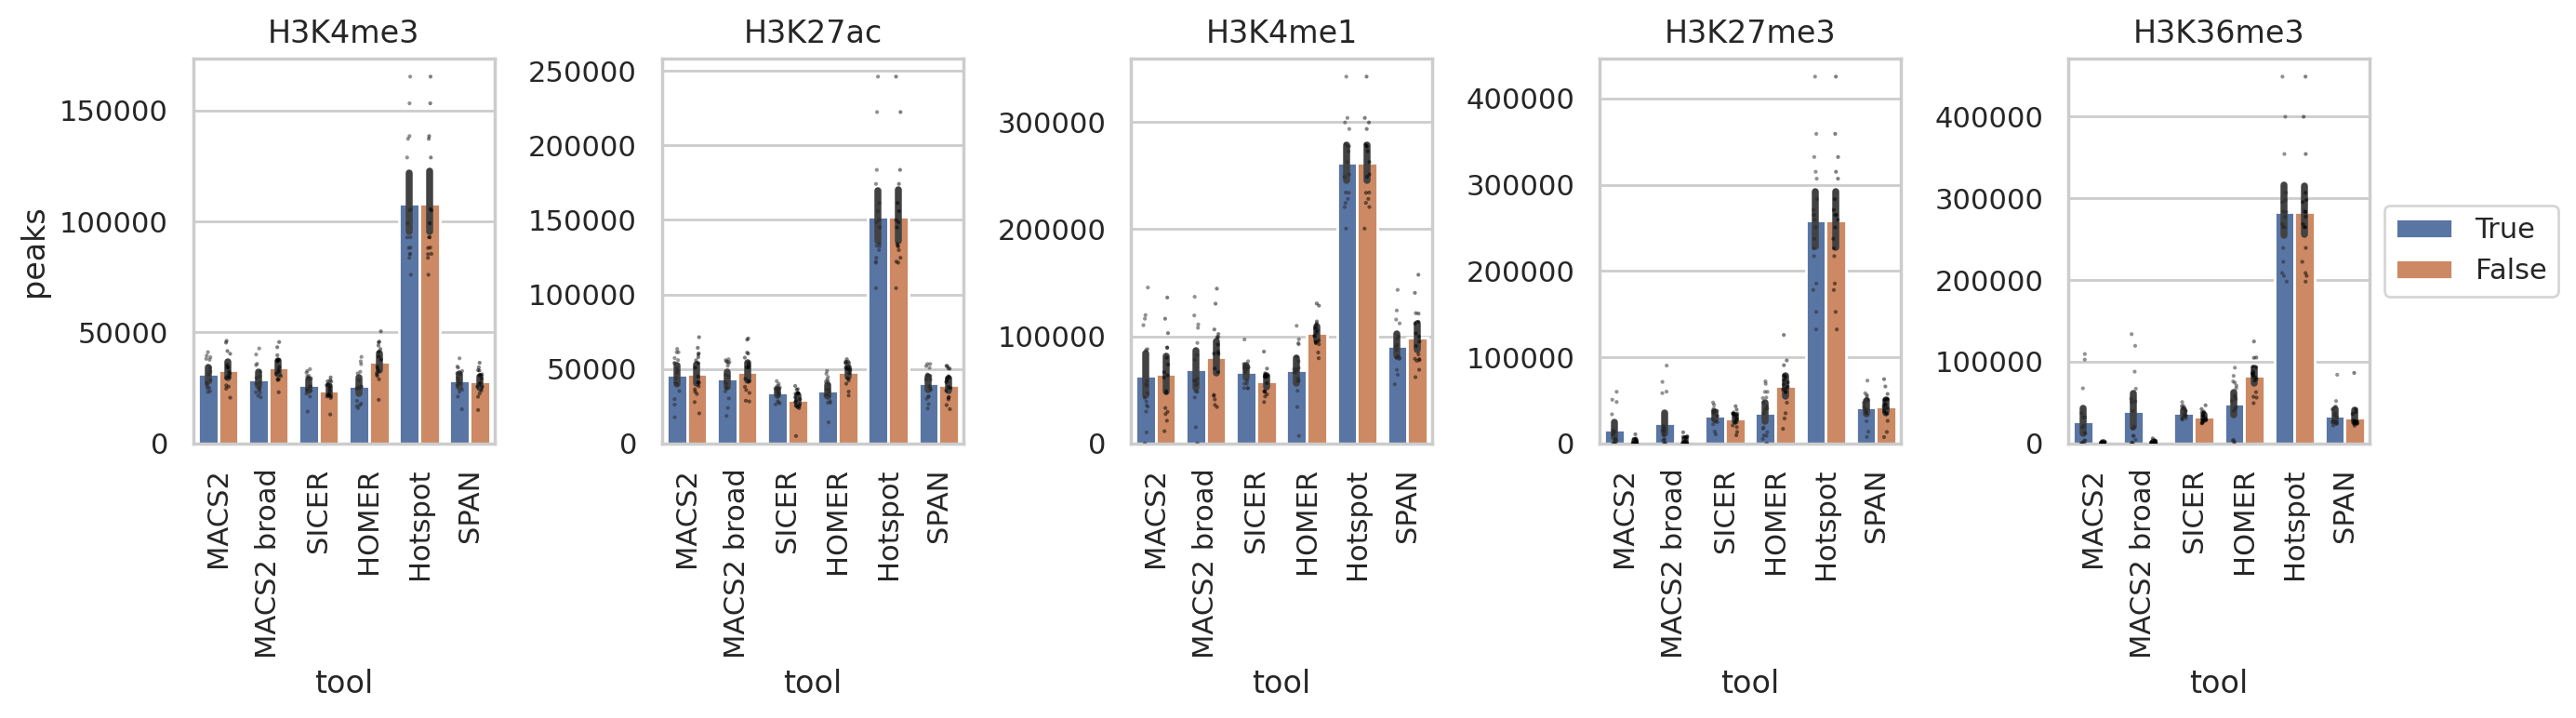

Roadmap


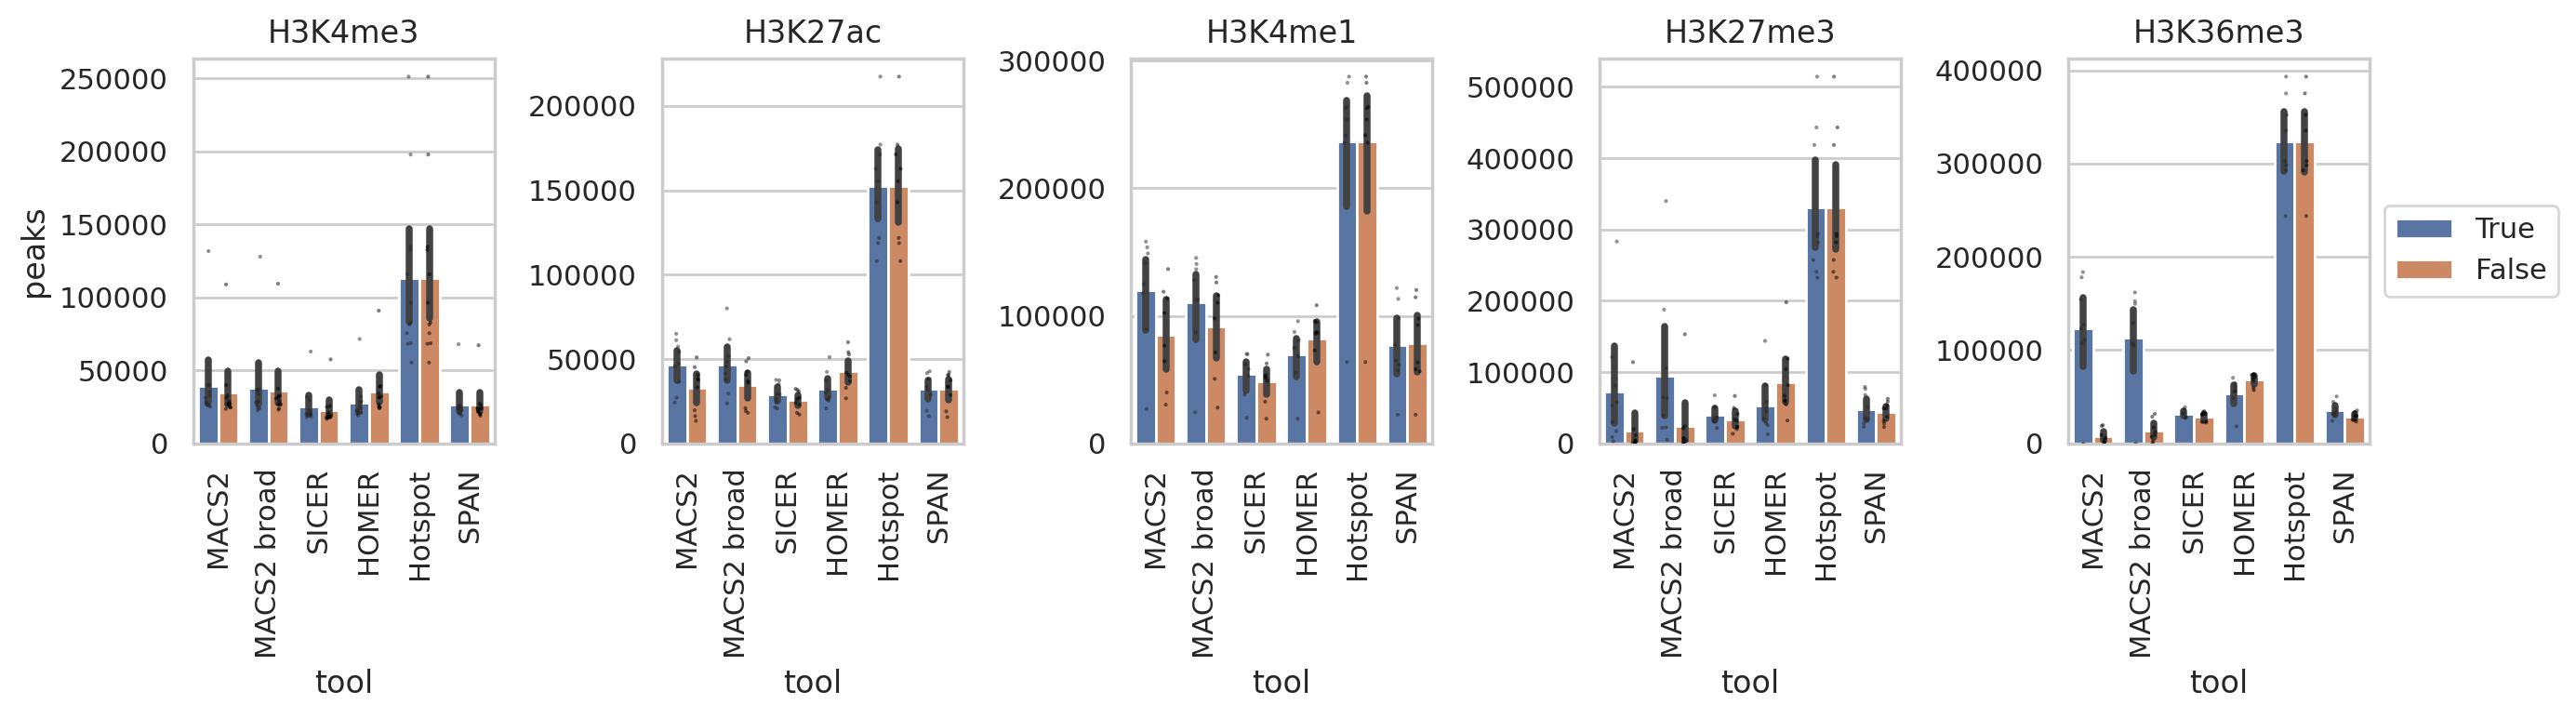

In [30]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(14, 4))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        sns.barplot(data=df_peaks_full[(df_peaks_full['dataset'] == ds) & 
                                  (df_peaks_full['modification'] == m)],
                    x='tool', y='peaks', hue='control',
                    # capsize=.2, err_kws={'linewidth': 2}, edgecolor="black",
                    order=TOOLS,
                    hue_order=[True, False],
                    ax=ax,)
        sns.stripplot(data=df_peaks_full[(df_peaks_full['dataset'] == ds) &
                                    (df_peaks_full['modification'] == m)],
                      x='tool', y='peaks', hue='control',
                      dodge=True, size=1.5, color="black", alpha=0.5, palette='dark:black',
                      order=TOOLS, legend=False,
                      hue_order=[True, False],
                      ax=ax)

        ax.xaxis.set_tick_params(rotation=90)
        ax.title.set_text(m)
        if i > 0:
            ax.set_ylabel(None)
        else:
            ax.set_ylabel('peaks')
        if i < 4:
            ax.legend().set_visible(False)
        else:
            # Put a legend to the right of the current axis
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # ax.set_ylim(0, 1.9e7)
    plt.tight_layout()
    # plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
    plt.show()

In [31]:
df_peaks_full[(df_peaks_full['tool'] == 'SPAN') & (df_peaks_full['modification'] == 'H3K27me3') & (df_peaks_full['peaks'] > 100_000)]

,file,modification,cell,replicate,peaks,tool,dataset,control


In [32]:
# Remove outliers, see figures.ipynb
OUTLIERS = [
    ('H3K4me3', 'NK', ''),
    ('H3K27ac', 'CD34', 'rep2'),
    ('H3K4me1', 'NK', ''),
    ('H3K27me3', 'BCell', ''),
    ('H3K27me3', 'TCell', ''),
    ('H3K27me3', 'NK', ''),
]
df_peaks = df_peaks_full.loc[[(m, c, r) not in OUTLIERS
                              for _, (m, c, r) in df_peaks_full[['modification', 'cell', 'replicate']].iterrows()]].copy()
df_peaks.sample(3)

,file,modification,cell,replicate,peaks,tool,dataset,control
826,/home/jetbrains/data/2023_GSE26320_no_control/...,H3K36me3,NHLF,rep1,36198,SPAN,ENCODE,False
522,/home/jetbrains/data/2023_GSE26320_no_control/...,H3K27ac,NHLF,rep2,50787,MACS2,ENCODE,False
224,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K4me3,H1,rep1,24202,SICER,ENCODE,True


ENCODE


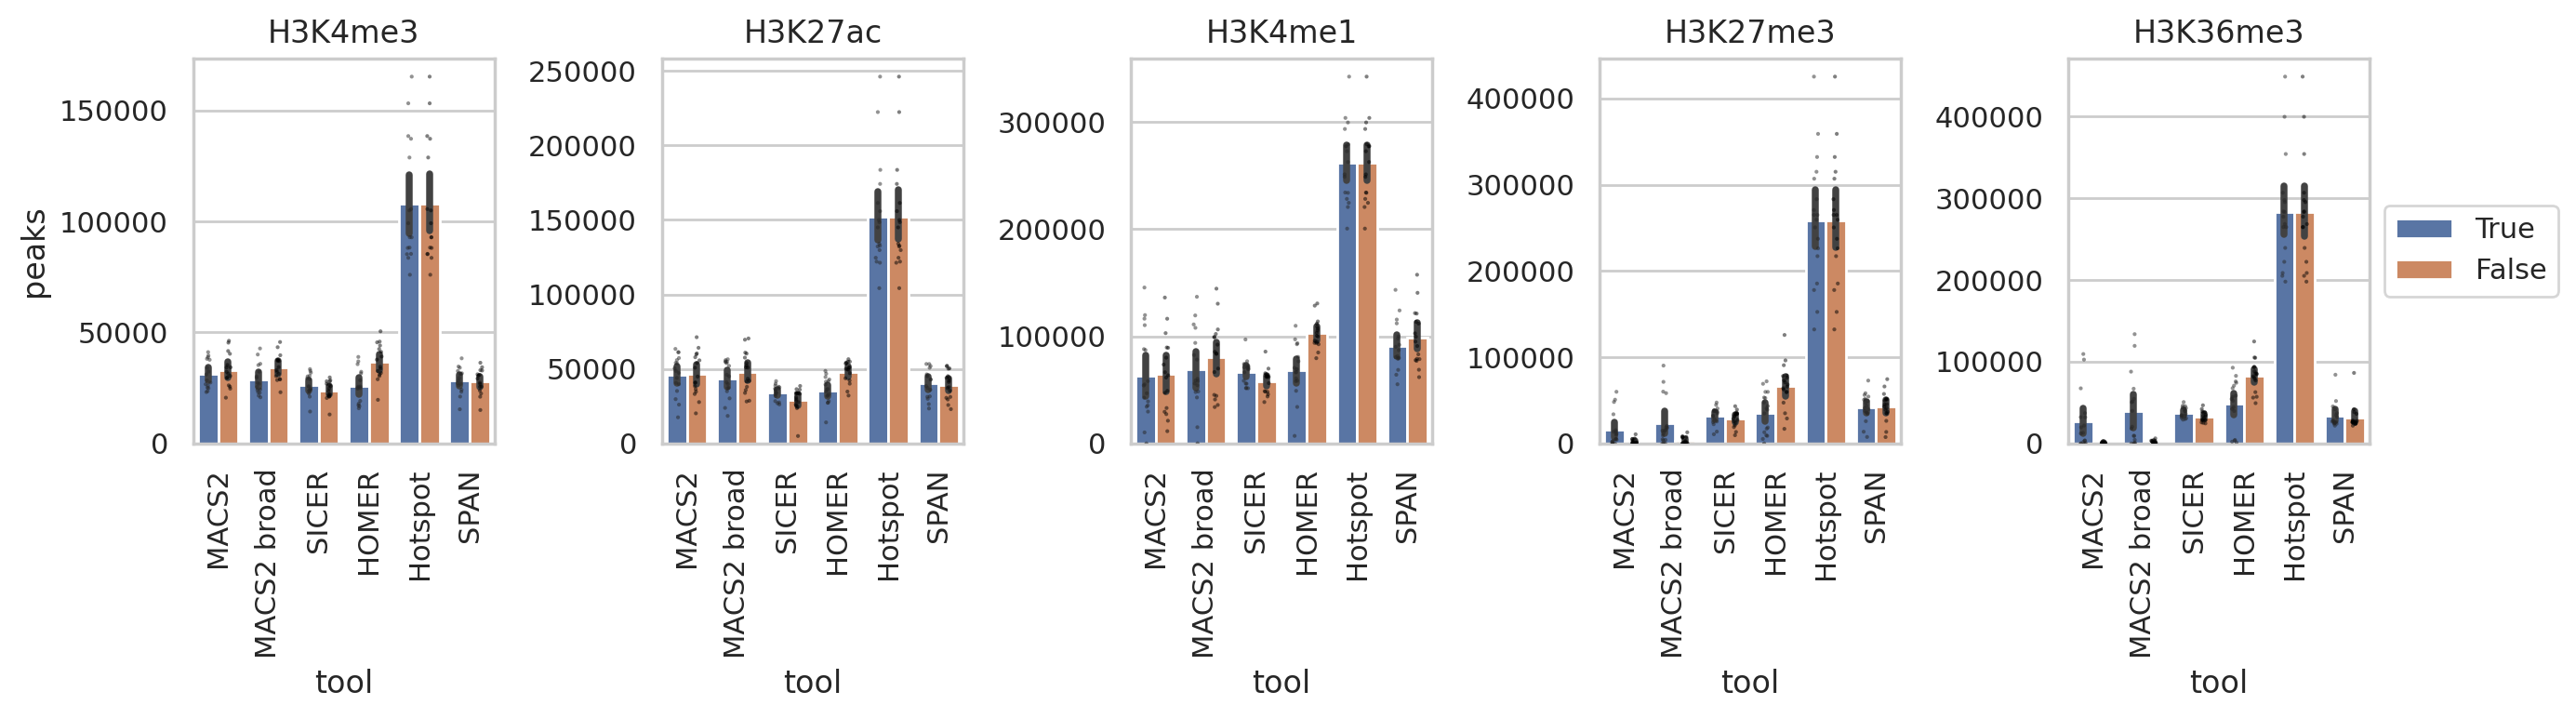

Roadmap


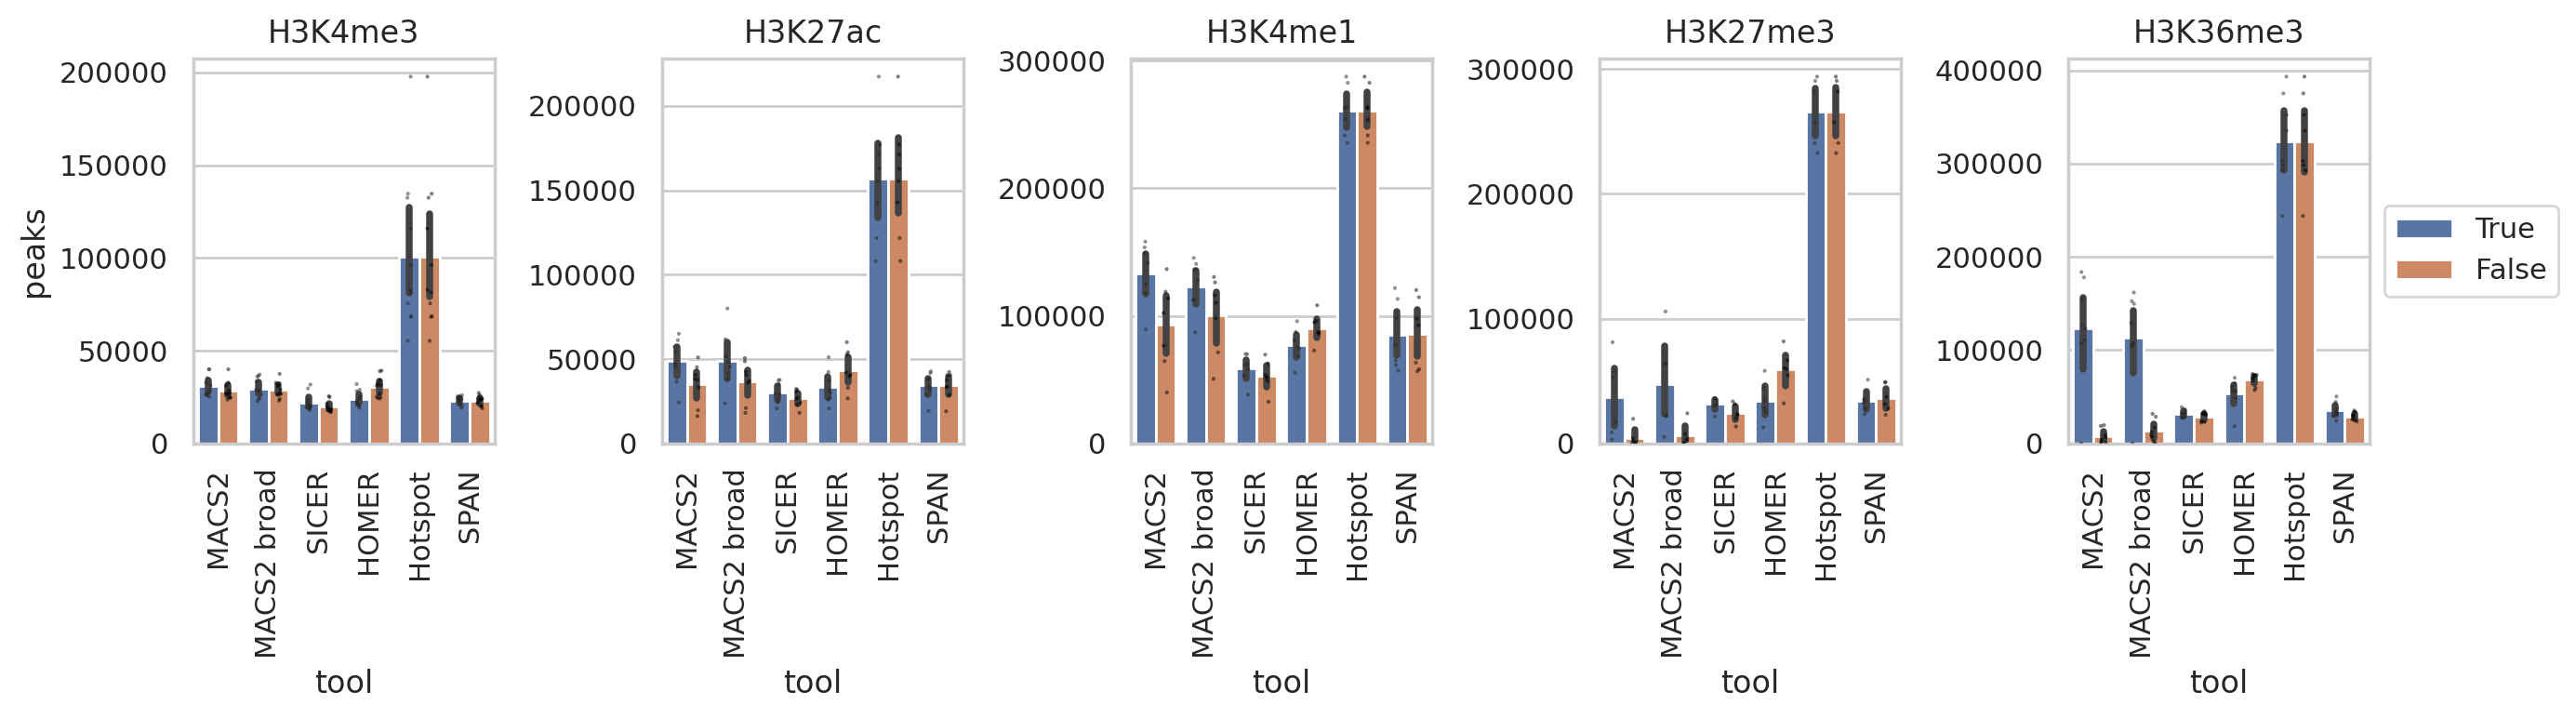

In [33]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(14, 4))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        sns.barplot(data=df_peaks[(df_peaks['dataset'] == ds) &
                                  (df_peaks['modification'] == m)],
                    x='tool', y='peaks', hue='control',
                    # capsize=.2, err_kws={'linewidth': 2}, edgecolor="black",
                    order=TOOLS,
                    hue_order=[True, False],
                    ax=ax,)
        sns.stripplot(data=df_peaks[(df_peaks['dataset'] == ds) &
                                    (df_peaks['modification'] == m)],
                      x='tool', y='peaks', hue='control',
                      dodge=True, size=1.5, color="black", alpha=0.5, palette='dark:black',
                      order=TOOLS, legend=False,
                      hue_order=[True, False],
                      ax=ax)

        ax.xaxis.set_tick_params(rotation=90)
        ax.title.set_text(m)
        if i > 0:
            ax.set_ylabel(None)
        else:
            ax.set_ylabel('peaks')
        if i < 4:
            ax.legend().set_visible(False)
        else:
            # Put a legend to the right of the current axis
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # ax.set_ylim(0, 1.9e7)
    plt.tight_layout()
    # plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
    plt.show()

NO CONTROL


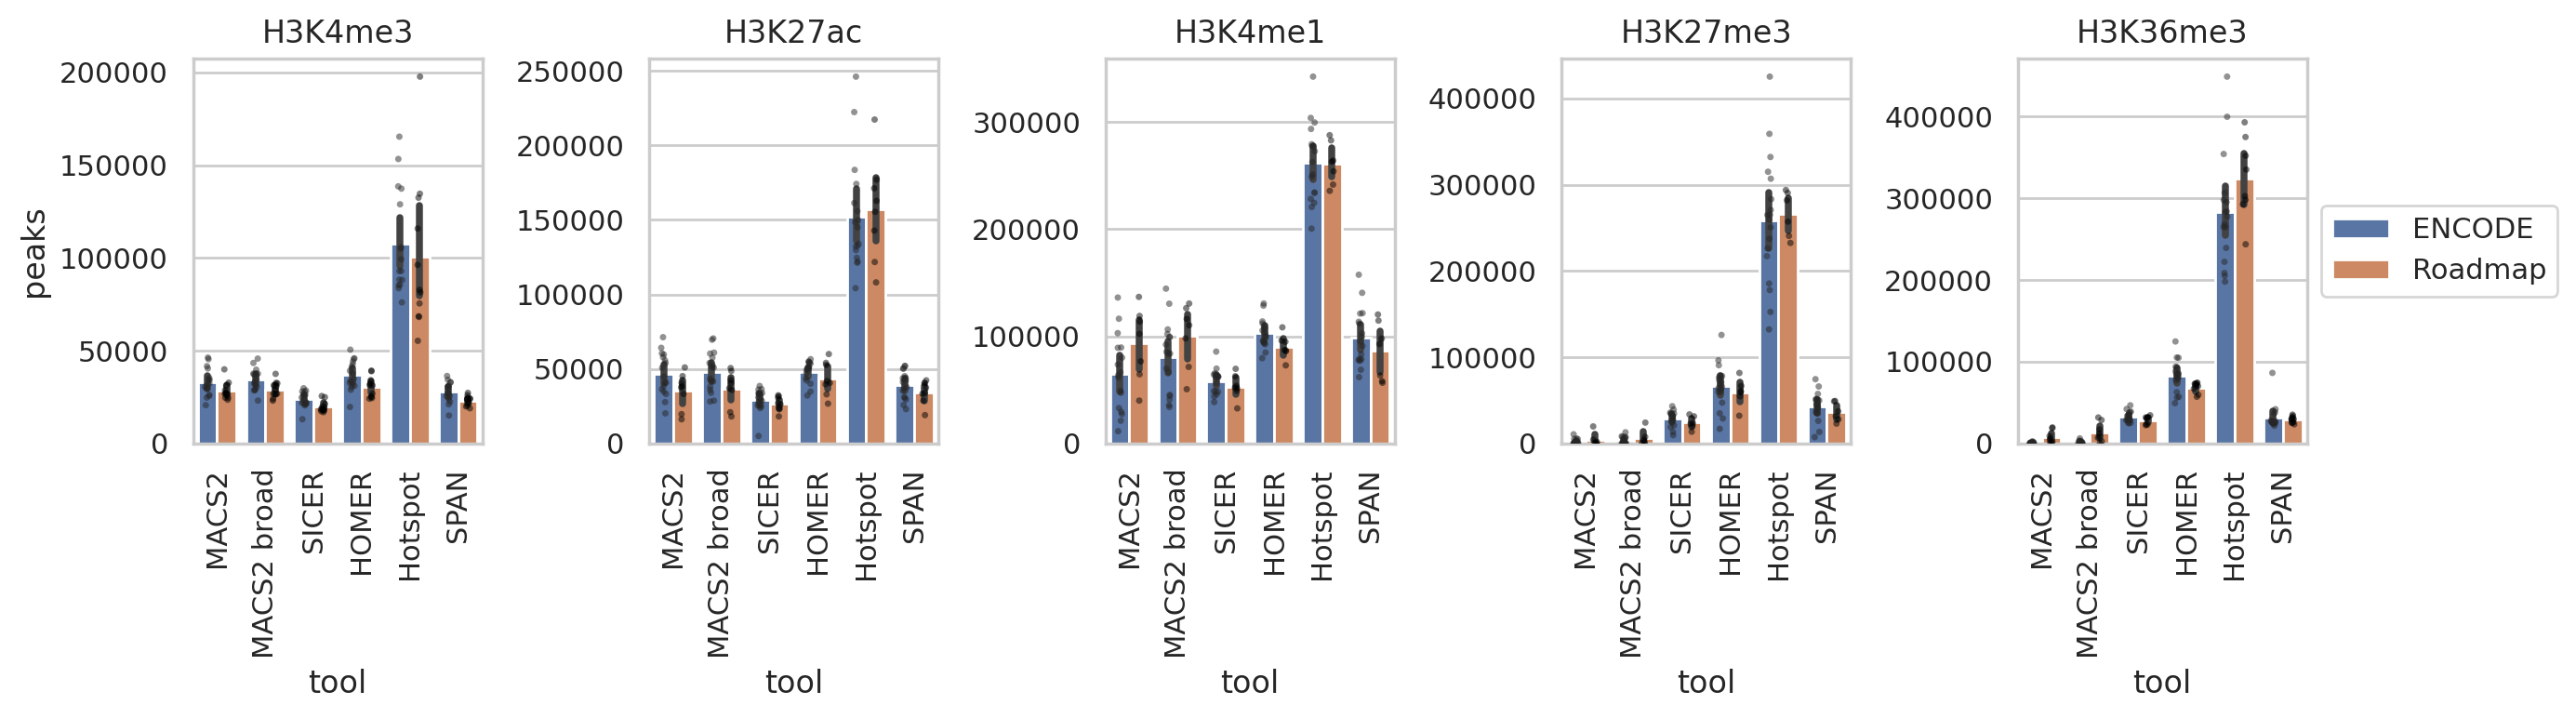

In [34]:
print('NO CONTROL')
plt.figure(figsize=(14, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.barplot(data=df_peaks[(df_peaks['modification'] == m) & (df_peaks['control'] == False)],
                x='tool', y='peaks', hue='dataset',
                # capsize=.2, err_kws={'linewidth': 2}, edgecolor="black",
                # palette=TOOLS_PALETTE,
                order=TOOLS,
                hue_order=['ENCODE', 'Roadmap'],
                ax=ax)
    sns.stripplot(data=df_peaks[(df_peaks['modification'] == m) & (df_peaks['control'] == False)],
                  x='tool', y='peaks',  hue='dataset',
                  dodge=True, size=2.5, palette='dark:black', alpha=0.5, legend=False,
                  order=TOOLS,
                  hue_order=['ENCODE', 'Roadmap'],
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < len(axs) -1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Compute ratio no control vs control

In [35]:
rows = []
for (ds, m, c, r, t), dft in tqdm(df_peaks.groupby(['dataset', 'modification', 'cell', 'replicate', 'tool'])):
    if len(dft) == 2:
        print(ds, m, c, r, t)
        if len(dft[dft['control'] == True]) != 1 or len(dft[dft['control'] == False]) != 1:
            continue
        with_control = dft[dft['control'] == True]['file'].values[0]
        without_control = dft[dft['control'] == False]['file'].values[0]
        peaks_with_control = lines(with_control)
        peaks_without_control = lines(without_control)
        rows.append((ds, m, c, r, t, d(peaks_without_control, peaks_with_control)))
df_ratio = pd.DataFrame(rows, columns=['dataset', 'modification', 'cell', 'replicate', 'tool', 'ratio'])
df_ratio['ratio'] = ((df_ratio['ratio'] - 1) * 100).astype(int)
del rows
df_ratio.sample(3)

  0%|          | 0/750 [00:00<?, ?it/s]

ENCODE H3K27ac GM12878 rep1 HOMER
ENCODE H3K27ac GM12878 rep1 Hotspot
ENCODE H3K27ac GM12878 rep1 MACS2
ENCODE H3K27ac GM12878 rep1 MACS2 broad
ENCODE H3K27ac GM12878 rep1 SICER
ENCODE H3K27ac GM12878 rep1 SPAN
ENCODE H3K27ac GM12878 rep2 HOMER
ENCODE H3K27ac GM12878 rep2 Hotspot
ENCODE H3K27ac GM12878 rep2 MACS2
ENCODE H3K27ac GM12878 rep2 MACS2 broad
ENCODE H3K27ac GM12878 rep2 SICER
ENCODE H3K27ac GM12878 rep2 SPAN
ENCODE H3K27ac H1 rep1 HOMER
ENCODE H3K27ac H1 rep1 Hotspot
ENCODE H3K27ac H1 rep1 MACS2
ENCODE H3K27ac H1 rep1 MACS2 broad
ENCODE H3K27ac H1 rep1 SICER
ENCODE H3K27ac H1 rep1 SPAN
ENCODE H3K27ac HMEC rep1 HOMER
ENCODE H3K27ac HMEC rep1 Hotspot
ENCODE H3K27ac HMEC rep1 MACS2
ENCODE H3K27ac HMEC rep1 MACS2 broad
ENCODE H3K27ac HMEC rep1 SICER
ENCODE H3K27ac HMEC rep1 SPAN
ENCODE H3K27ac HMEC rep2 HOMER
ENCODE H3K27ac HMEC rep2 Hotspot
ENCODE H3K27ac HMEC rep2 MACS2
ENCODE H3K27ac HMEC rep2 MACS2 broad
ENCODE H3K27ac HMEC rep2 SICER
ENCODE H3K27ac HMEC rep2 SPAN
ENCODE H3K2

,dataset,modification,cell,replicate,tool,ratio
686,Roadmap,H3K4me3,BCell,,MACS2,9
114,ENCODE,H3K27me3,H1,rep1,HOMER,30
323,ENCODE,H3K4me1,GM12878,rep2,SPAN,-14


ENCODE


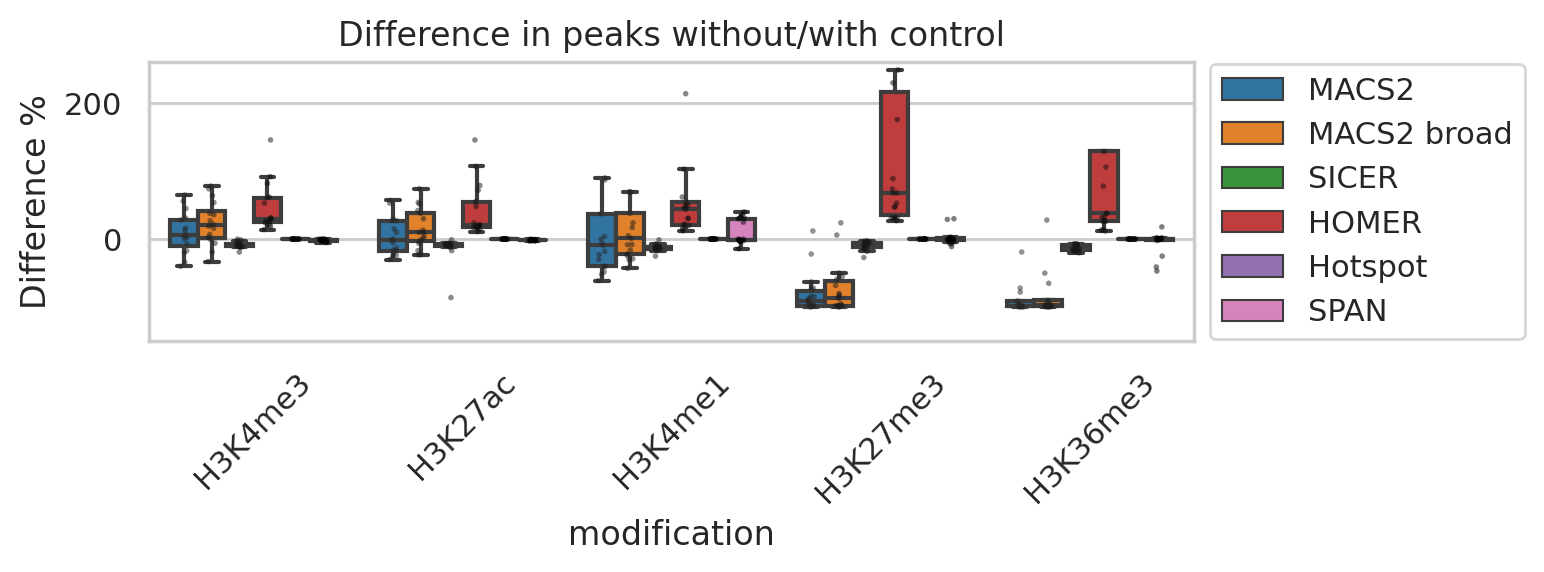

Roadmap


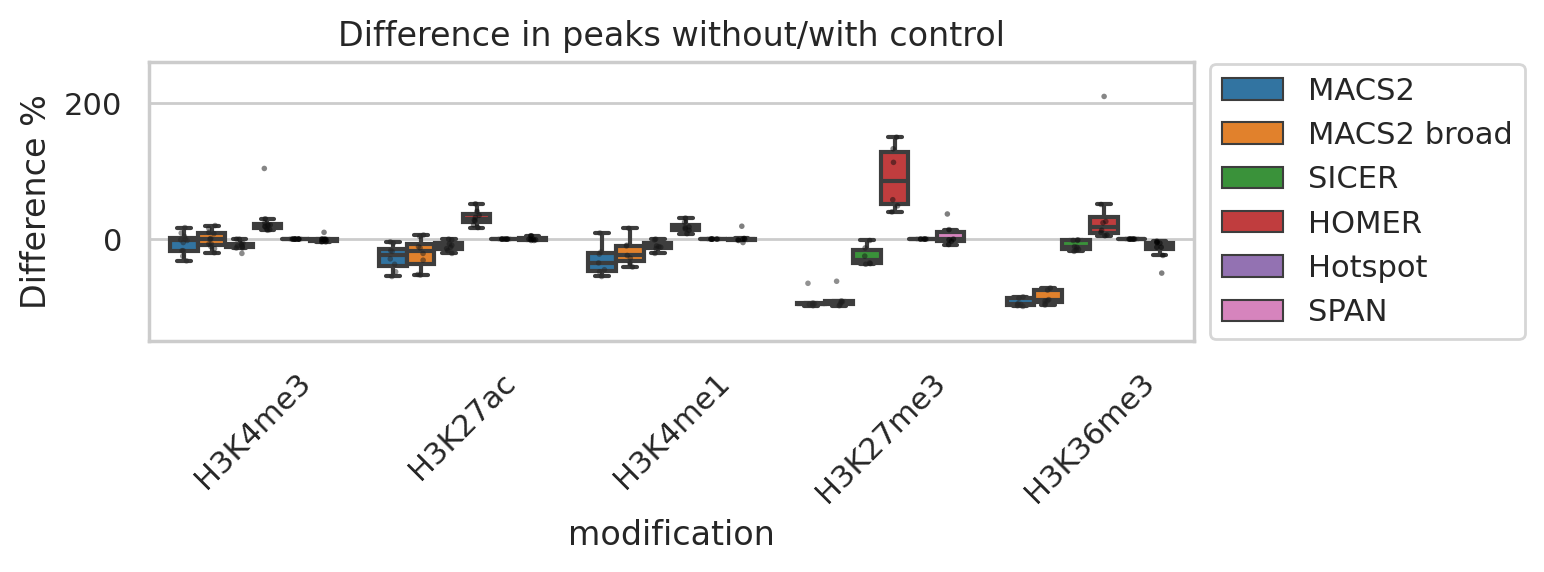

In [36]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(8, 3))
    ax = plt.axes()
    sns.boxplot(data=df_ratio[df_ratio['dataset'] == ds],
                x='modification', y='ratio', hue='tool',
                showfliers=False,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
                hue_order=TOOLS,
                palette = TOOLS_PALETTE,
                ax=ax)
    sns.stripplot(data=df_ratio[df_ratio['dataset'] == ds],
                  x='modification', y='ratio', hue='tool',
                  dodge=True, size=2, color="black", alpha=0.5, palette='dark:black',
                  order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
                  hue_order=TOOLS, legend=False,
                  ax=ax)
    ax.set_ylabel('Difference %')
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_ylim(-150, 260)
    ax.set_title('Difference in peaks without/with control')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

In [37]:
df_ratio[(df_ratio['tool'] == 'MACS2') & 
         (df_ratio['modification'] == 'H3K4me3') & (df_ratio['ratio'] > 50)]

,dataset,modification,cell,replicate,tool,ratio
440,ENCODE,H3K4me3,HMEC,rep1,MACS2,56
464,ENCODE,H3K4me3,HepG2,rep2,MACS2,65


ENCODE + Roadmap


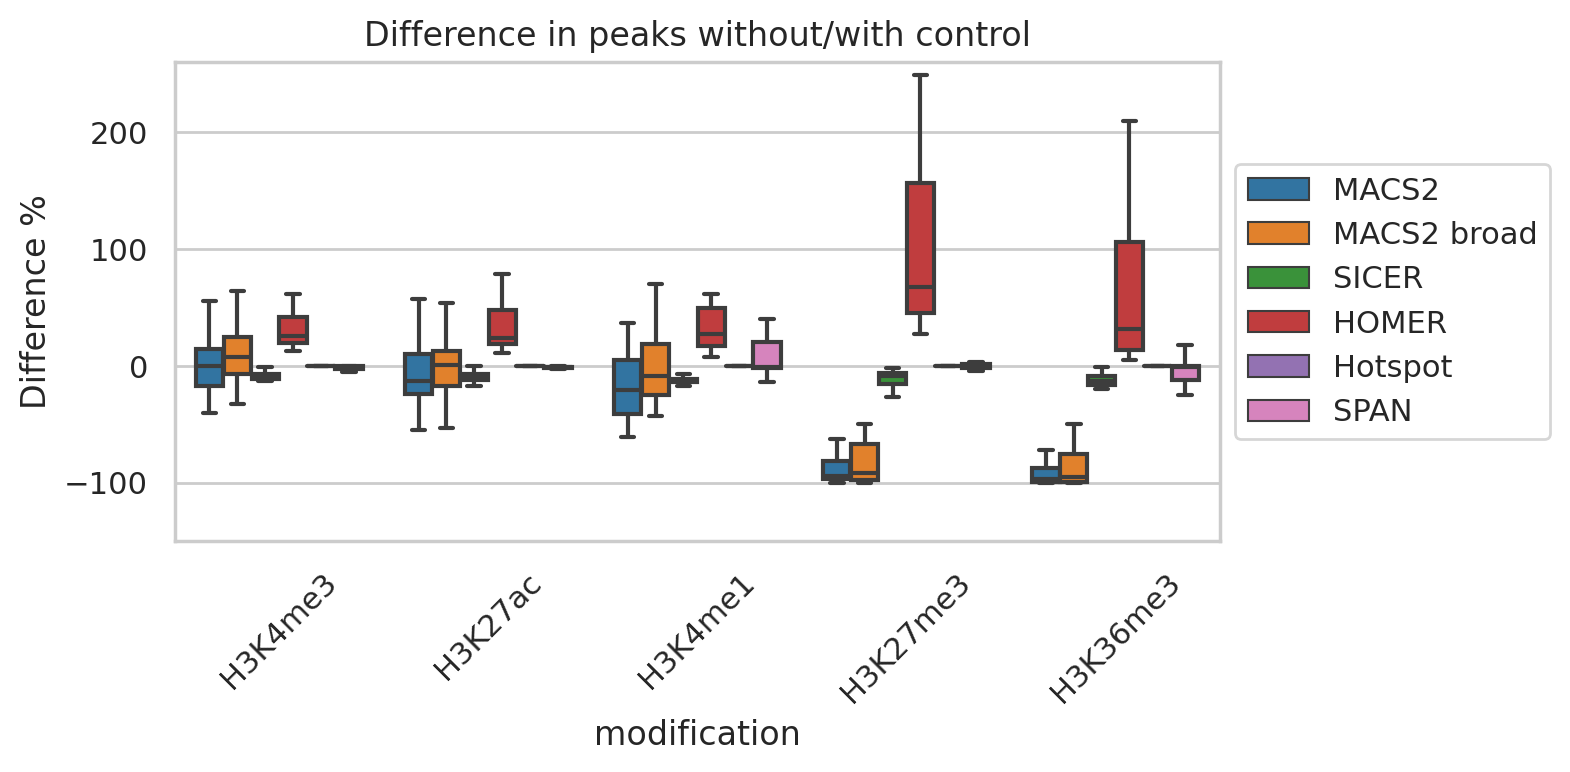

In [38]:
print('ENCODE + Roadmap')
plt.figure(figsize=(8, 4))
ax = plt.axes()
sns.boxplot(data=df_ratio,
            x='modification', y='ratio', hue='tool',
            showfliers=False,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
            hue_order=TOOLS,
            palette = TOOLS_PALETTE,
            ax=ax)
# sns.stripplot(data=df_ratio,
#               x='modification', y='ratio', hue='tool',
#               dodge=True, size=3, alpha=0.5,
#               order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
#               hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
#               palette='dark:black',
#               ax=ax)
ax.set_ylabel('Difference %')
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylim(-150, 260)
ax.set_title('Difference in peaks without/with control')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [45]:
tf = tempfile.mktemp()
rows = []
for (ds, m, c, r, t), dft in tqdm(df_peaks.groupby(['dataset', 'modification', 'cell', 'replicate', 'tool'])):
    if len(dft) == 2:
        with_control = sorted_file(dft[dft['control'] == True]['file'].values[0])
        without_control = sorted_file(dft[dft['control'] == False]['file'].values[0])
        peaks_with_control = lines(with_control)
        peaks_without_control = lines(without_control)
        len_with_control = bedl(with_control).sum()
        len_without_control = bedl(without_control).sum()
        !bedtools intersect -a {with_control} -b {without_control} -wo > {tf}
        overlap_len = int(last_col(tf).sum())
        jaccard = d(overlap_len, len_with_control + len_without_control - overlap_len)
        rows.append((ds, m, c, r, t, peaks_with_control, peaks_without_control, len_with_control, len_without_control, 
                     d(len_with_control, peaks_with_control), d(len_without_control, peaks_without_control),
                     overlap_len, jaccard))
df_jaccard = pd.DataFrame(rows, columns=['dataset', 'modification', 'cell', 'replicate', 'tool',
                                         'peaks_with_control', 'peaks_without_control',
                                         'len_with_control', 'len_without_control', 
                                         'avg_len_with_control', 'avg_len_without_control',
                                         'overlap_len', 'jaccard'])
del rows
df_jaccard.sample(3)

  0%|          | 0/750 [00:00<?, ?it/s]

,dataset,modification,cell,replicate,tool,peaks_with_control,peaks_without_control,len_with_control,len_without_control,avg_len_with_control,avg_len_without_control,overlap_len,jaccard
420,ENCODE,H3K4me3,GM12878,rep2,HOMER,35727,45546,66046579.0,86082409,1848.646094,1890.010297,66037579,0.767064
480,ENCODE,H3K4me3,K562,rep1,HOMER,28472,45889,51361906.0,79284911,1803.944437,1727.754168,51361906,0.647814
22,ENCODE,H3K27ac,HMEC,rep1,SICER,36689,33471,146221711.0,140029929,3985.437352,4183.619521,138286859,0.934593


ENCODE


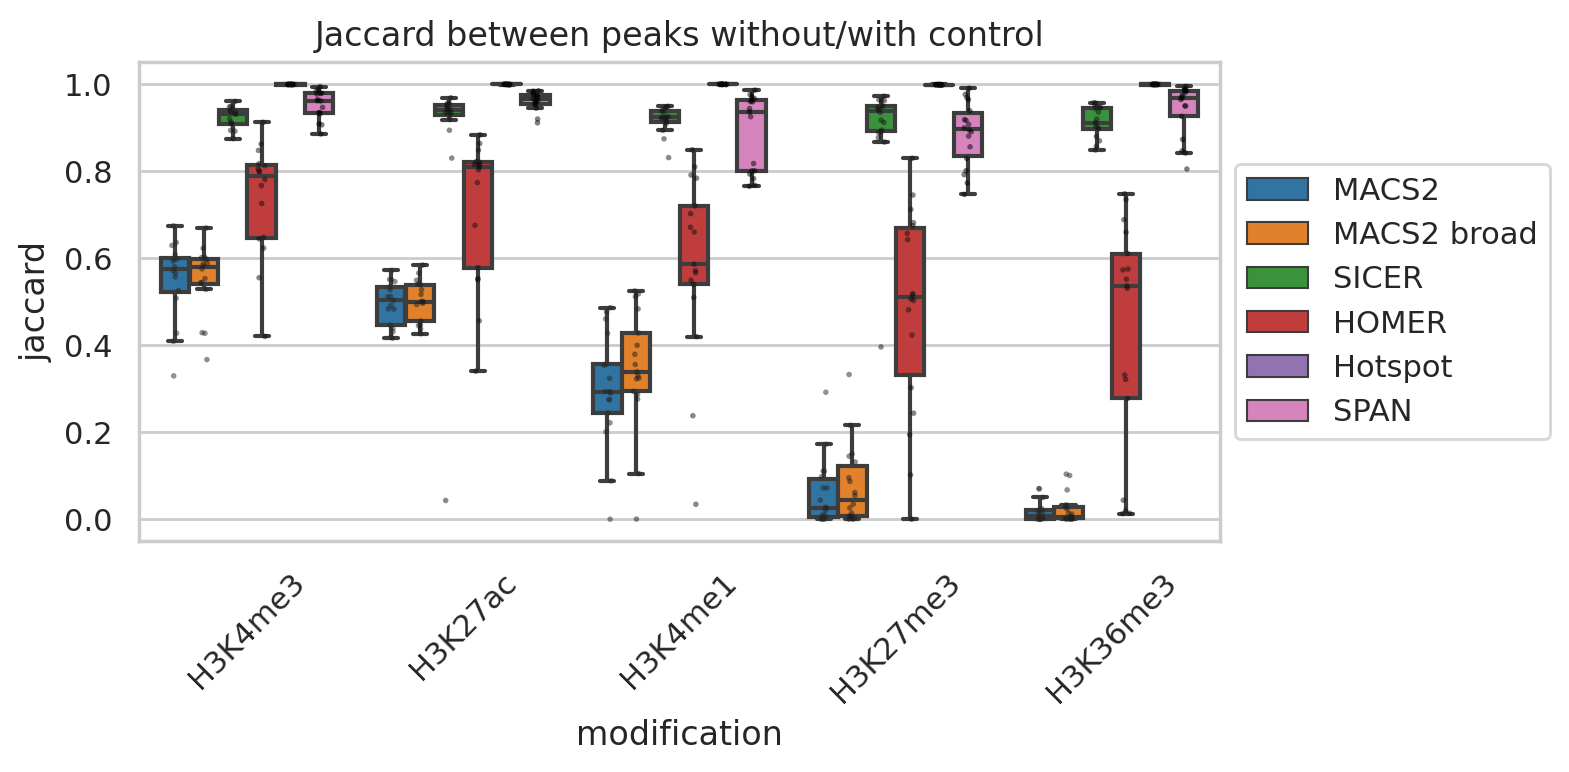

Roadmap


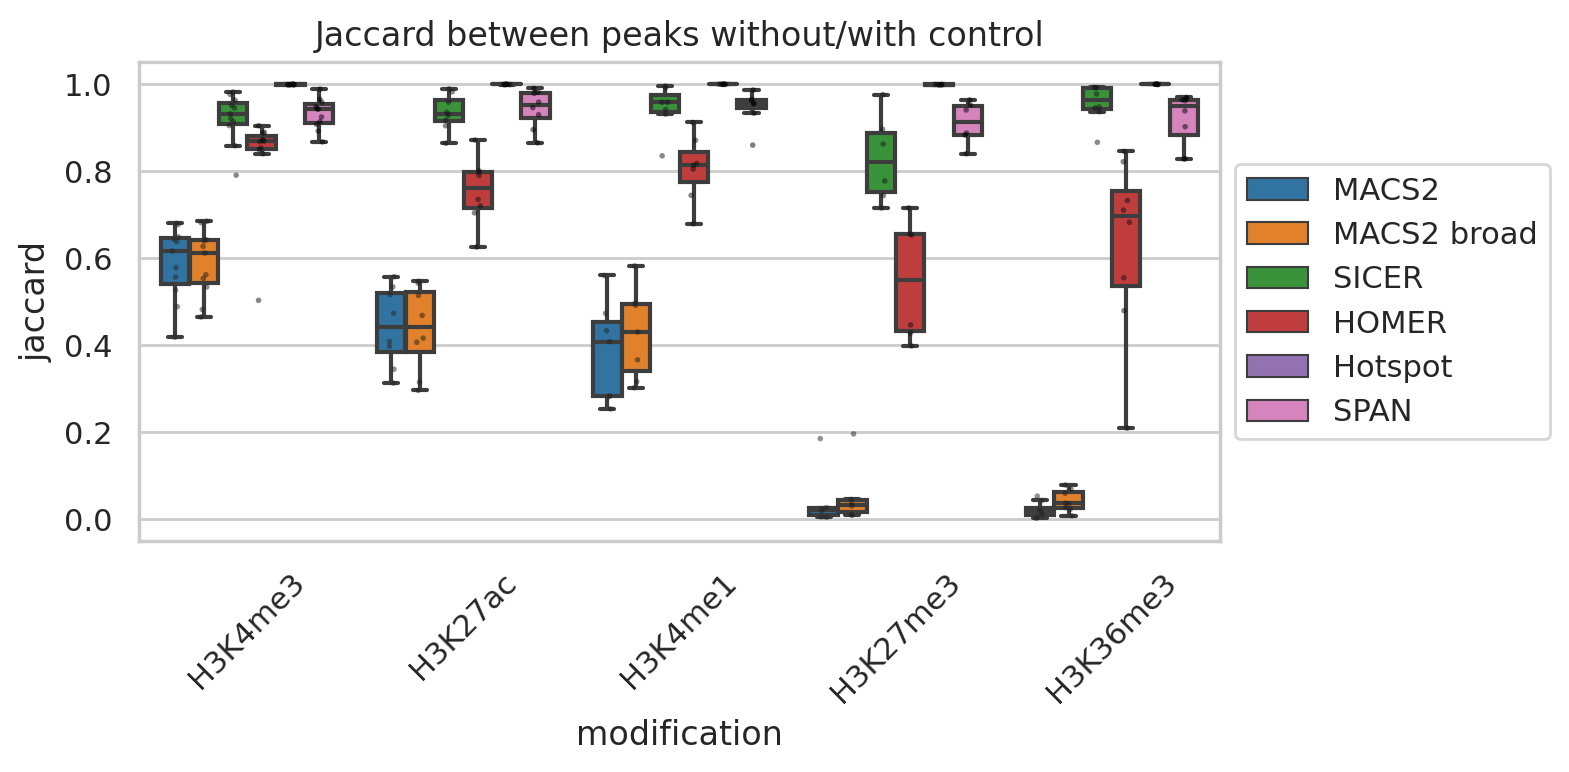

In [50]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(8, 4))
    ax = plt.axes()
    sns.boxplot(data=df_jaccard[df_jaccard['dataset'] == ds],
                x='modification', y='jaccard', hue='tool',
                showfliers=False,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
                hue_order=TOOLS,
                palette = TOOLS_PALETTE,
                ax=ax)
    sns.stripplot(data=df_jaccard[df_jaccard['dataset'] == ds],
                  x='modification', y='jaccard', hue='tool',
                  dodge=True, size=2, color="black", alpha=0.5, palette='dark:black',
                  order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
                  hue_order=TOOLS, legend=False,
                  ax=ax)
    ax.set_ylabel('jaccard')
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_ylim(-0.05, 1.05)
    ax.set_title('Jaccard between peaks without/with control')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

In [47]:
df_jaccard[(df_jaccard['tool'] == 'SPAN') &
           (df_jaccard['modification'] == 'H3K27me3') & 
           (df_jaccard['jaccard'] < 0.1)]

,dataset,modification,cell,replicate,tool,peaks_with_control,peaks_without_control,len_with_control,len_without_control,avg_len_with_control,avg_len_without_control,overlap_len,jaccard


ENCODE + Roadmap


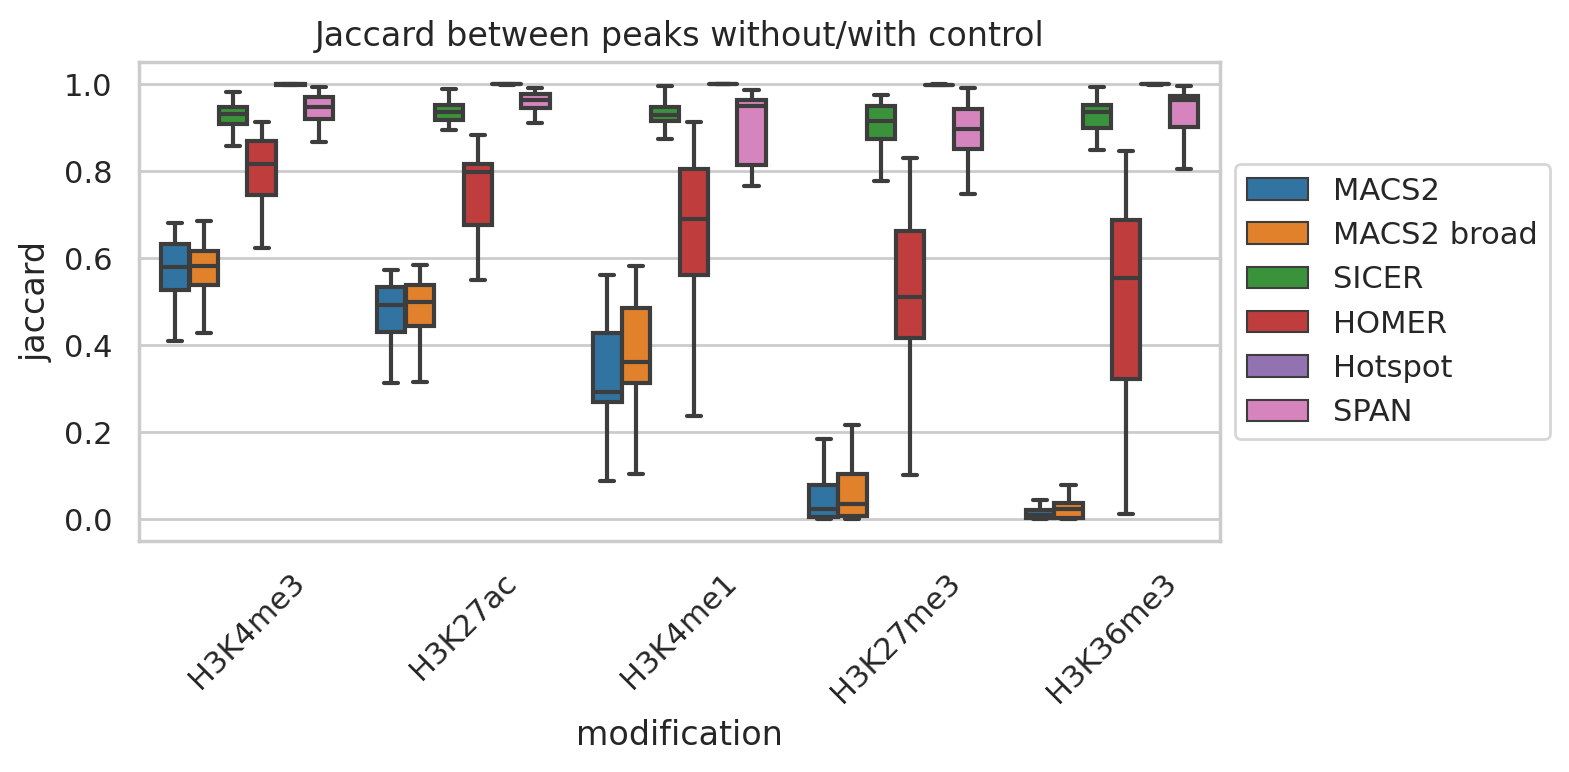

In [51]:
print('ENCODE + Roadmap')
plt.figure(figsize=(8, 4))
ax = plt.axes()
sns.boxplot(data=df_jaccard,
            x='modification', y='jaccard', hue='tool',
            showfliers=False,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
            hue_order=TOOLS,
            palette = TOOLS_PALETTE,
            ax=ax)
# sns.stripplot(data=df_jaccard,
#               x='modification', y='jaccard', hue='tool',
#               dodge=True, size=3, color="black", alpha=0.5, palette='dark:black',
#               order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
#               hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
#               ax=ax)
ax.set_ylabel('jaccard')
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylim(-0.05, 1.05)
ax.set_title('Jaccard between peaks without/with control')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# END